Mount Drive


In [1]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary Libaries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import time


##### Checking for cuda 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

RefineNet Model and required Blocks

In [0]:
def batchnorm(in_planes):
    "batch norm 2d"
    return nn.BatchNorm2d(in_planes, affine=True, eps=1e-5, momentum=0.1)

def conv3x3(in_planes, out_planes, stride=1, bias=False):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=bias)

def conv1x1(in_planes, out_planes, stride=1, bias=False):
    "1x1 convolution"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     padding=0, bias=bias)

def convbnrelu(in_planes, out_planes, kernel_size, stride=1, groups=1, act=True):
    "conv-batchnorm-relu"
    if act:
        return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_planes),
                             nn.ReLU6(inplace=True))
    else:
        return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_planes))

class CRPBlock(nn.Module):

    def __init__(self, in_planes, out_planes, n_stages):
        super(CRPBlock, self).__init__()
        for i in range(n_stages):
            setattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'),
                    conv3x3(in_planes if (i == 0) else out_planes,
                            out_planes, stride=1,
                            bias=False))
        self.stride = 1
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        top = x
        for i in range(self.n_stages):
            top = self.maxpool(top)
            top = getattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'))(top)
            x = top + x
        return x
    
stages_suffixes = {0 : '_conv',
                   1 : '_conv_relu_varout_dimred'}
    
class RCUBlock(nn.Module):
    
    def __init__(self, in_planes, out_planes, n_blocks, n_stages):
        super(RCUBlock, self).__init__()
        for i in range(n_blocks):
            for j in range(n_stages):
                setattr(self, '{}{}'.format(i + 1, stages_suffixes[j]),
                        conv3x3(in_planes if (i == 0) and (j == 0) else out_planes,
                                out_planes, stride=1,
                                bias=(j == 0)))
        self.stride = 1
        self.n_blocks = n_blocks
        self.n_stages = n_stages
    
    def forward(self, x):
        for i in range(self.n_blocks):
            residual = x
            for j in range(self.n_stages):
                x = F.relu(x)
                x = getattr(self, '{}{}'.format(i + 1, stages_suffixes[j]))(x)
            x += residual
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class RefineNet(nn.Module):

    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(RefineNet, self).__init__()
        self.do = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.p_ims1d2_outl1_dimred = conv3x3(2048, 512, bias=False)
        self.adapt_stage1_b = self._make_rcu(512, 512, 2, 2)
        self.mflow_conv_g1_pool = self._make_crp(512, 512, 4)
        self.mflow_conv_g1_b = self._make_rcu(512, 512, 3, 2)
        self.mflow_conv_g1_b3_joint_varout_dimred = conv3x3(512, 256, bias=False)
        self.p_ims1d2_outl2_dimred = conv3x3(1024, 256, bias=False)
        self.adapt_stage2_b = self._make_rcu(256, 256, 2, 2)
        self.adapt_stage2_b2_joint_varout_dimred = conv3x3(256, 256, bias=False)
        self.mflow_conv_g2_pool = self._make_crp(256, 256, 4)
        self.mflow_conv_g2_b = self._make_rcu(256, 256, 3, 2)
        self.mflow_conv_g2_b3_joint_varout_dimred = conv3x3(256, 256, bias=False)

        self.p_ims1d2_outl3_dimred = conv3x3(512, 256, bias=False)
        self.adapt_stage3_b = self._make_rcu(256, 256, 2, 2)
        self.adapt_stage3_b2_joint_varout_dimred = conv3x3(256, 256, bias=False)
        self.mflow_conv_g3_pool = self._make_crp(256, 256, 4)
        self.mflow_conv_g3_b = self._make_rcu(256, 256, 3, 2)
        self.mflow_conv_g3_b3_joint_varout_dimred = conv3x3(256, 256, bias=False)

        self.p_ims1d2_outl4_dimred = conv3x3(256, 256, bias=False)
        self.adapt_stage4_b = self._make_rcu(256, 256, 2, 2)
        self.adapt_stage4_b2_joint_varout_dimred = conv3x3(256, 256, bias=False)
        self.mflow_conv_g4_pool = self._make_crp(256, 256, 4)
        self.mflow_conv_g4_b = self._make_rcu(256, 256, 3, 2)

        self.clf_conv = nn.Conv2d(256, num_classes, kernel_size=3, stride=1,
                                  padding=1, bias=True)
        # self.sig = nn.Sigmoid()

    def _make_crp(self, in_planes, out_planes, stages):
        layers = [CRPBlock(in_planes, out_planes,stages)]
        return nn.Sequential(*layers)
    
    def _make_rcu(self, in_planes, out_planes, blocks, stages):
        layers = [RCUBlock(in_planes, out_planes, blocks, stages)]
        return nn.Sequential(*layers)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # print('x= ',x)

        l1 = self.layer1(x)
        l2 = self.layer2(l1)
        l3 = self.layer3(l2)
        l4 = self.layer4(l3)

        

        l4 = self.do(l4)
        l3 = self.do(l3)

        # print('l1= ', l1)
        # print('l2= ', l2)
        # print('l3= ', l3)
        # print('l4= ', l4)

        x4 = self.p_ims1d2_outl1_dimred(l4)
        x4 = self.adapt_stage1_b(x4)
        x4 = self.relu(x4)
        x4 = self.mflow_conv_g1_pool(x4)
        x4 = self.mflow_conv_g1_b(x4)
        x4 = self.mflow_conv_g1_b3_joint_varout_dimred(x4)
        x4 = nn.Upsample(size=l3.size()[2:], mode='bilinear', align_corners=True)(x4)

        # print('x4= ', x4)

        x3 = self.p_ims1d2_outl2_dimred(l3)
        x3 = self.adapt_stage2_b(x3)
        x3 = self.adapt_stage2_b2_joint_varout_dimred(x3)
        x3 = x3 + x4
        x3 = F.relu(x3)
        x3 = self.mflow_conv_g2_pool(x3)
        x3 = self.mflow_conv_g2_b(x3)
        x3 = self.mflow_conv_g2_b3_joint_varout_dimred(x3)
        x3 = nn.Upsample(size=l2.size()[2:], mode='bilinear', align_corners=True)(x3)

        # print('x3= ', x3)

        x2 = self.p_ims1d2_outl3_dimred(l2)
        x2 = self.adapt_stage3_b(x2)
        x2 = self.adapt_stage3_b2_joint_varout_dimred(x2)
        x2 = x2 + x3
        x2 = F.relu(x2)
        x2 = self.mflow_conv_g3_pool(x2)
        x2 = self.mflow_conv_g3_b(x2)
        x2 = self.mflow_conv_g3_b3_joint_varout_dimred(x2)
        x2 = nn.Upsample(size=l1.size()[2:], mode='bilinear', align_corners=True)(x2)

        # print('x2= ', x2)

        x1 = self.p_ims1d2_outl4_dimred(l1)
        x1 = self.adapt_stage4_b(x1)
        x1 = self.adapt_stage4_b2_joint_varout_dimred(x1)
        x1 = x1 + x2
        x1 = F.relu(x1)
        x1 = self.mflow_conv_g4_pool(x1)
        x1 = self.mflow_conv_g4_b(x1)
        x1 = self.do(x1)

        # print('x1= ', x1)

        out = self.clf_conv(x1)
        # out = self.sig(x1)
        return out

Transforms for loading data

In [8]:
print('==> Preparing data..')
transform_train = transforms.Compose([
#     transforms.RandomCrop(128),
#     transforms.RandomHorizontalFlip(),
    transforms.Resize((375,1242)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_train_label = transforms.Compose([
#     transforms.RandomCrop(128),
#     transforms.RandomHorizontalFlip(),
    # transforms.Resize((32,32)),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    # transforms.Resize((128,128)),  
    transforms.Resize((375,1242)),                                   
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


Function to load data

In [0]:
def loader(img_dir, img_dir_label):

    training = []
    labels = []
    size_label = (311,94)

    color = [128,64,128]
    
    for name in os.listdir(img_dir):
        try:
            training.append(transform_train(Image.open(img_dir + name)))
            label = cv2.imread(img_dir_label + name, 0)
            label = cv2.resize(label, size_label)
            labels.append(transform_train_label(label))
        except:
            pass

    training = torch.stack(training) 
    labels = torch.stack(labels)

    train = torch.utils.data.TensorDataset(training,labels)
    train_loader = torch.utils.data.DataLoader(train)

    return train_loader

In [6]:
#### Loading data

img_dir_train = '/content/drive/My Drive/data_kitti/training_new/images/'
img_dir_label = '/content/drive/My Drive/data_kitti/training_new/labels/'

img_dir_test = '/content/drive/My Drive/data_kitti/testing_new/images/'
img_dir_test_label = '/content/drive/My Drive/data_kitti/testing_new/labels/'

train_loader = loader(img_dir_train, img_dir_label)
test_loader = loader(img_dir_test, img_dir_test_label)

FileNotFoundError: ignored

In [0]:
def create_model(classes):
    net = RefineNet(Bottleneck, [3, 4, 23, 3], num_classes=classes).to(device)
    m = net.eval()

    return net

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint
    
    for parameter in model.parameters():
        parameter.requires_grad = True

    m = model.eval()
    return model

In [0]:
### Path for saving and loading model
# PATH = '/content/drive/My Drive/Models/refineNetData.pt'   ##### Original Model Trained on 200 images of Kitti

PATH = '/content/drive/My Drive/Models/refineNetData.pt'

In [13]:
# net = create_model(2)
net = load_checkpoint(PATH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [0]:
def train(net, train_loader, num_epoch, lr, PATH=PATH, with_graph=False, save_=False):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0)

    j = 0
    j_list = []
    loss_list = []
    for epoch in range(0, num_epoch):

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, label = data

            inputs = inputs.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, label[0].long())
            
            loss.backward(retain_graph=True)
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        
        running_loss /= len(train_loader)
        print('running loss => ', running_loss)
        j+=1
        if with_graph and epoch%10==0:
            j_list.append(j)
            loss_list.append(running_loss)
            plt.plot(j_list, loss_list)
            plt.pause(0.00001)

        if save_ and epoch%10==0:
            torch.save(net, PATH)

    #     print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
    torch.save(net, PATH)
    return net

In [0]:
net = train(net, train_loader, 20, 0.00001, with_graph=True, save_=True)

In [0]:
net = train(net, train_loader, 30, 0.000001, with_graph=True, save_=True)

In [0]:
net = train(net, train_loader, 100, 0.0000001, with_graph=True, save_=True)

In [0]:
net = train(net, train_loader, 50, 0.00000001, with_graph=True, save_=True)

In [0]:
net = load_checkpoint(PATH)

In [0]:
#### Function to normalise
def norm(vector):
    min_v = torch.min(vector)
    range_v = torch.max(vector) - min_v
    if range_v > 0:
        normalised = (vector - min_v) / range_v
    else:
        normalised = torch.zeros(vector.size())
    return normalised

#### Testing Function
def predict_image(image):
    image_tensor = transform_test(image)
    image_tensor = image_tensor.unsqueeze(0)
    inputs = Variable(image_tensor)
    inputs = inputs.to(device)
    output = net(inputs.to(device))
    return output

In [0]:
#### Test

def test(img_test_dir, prob):
    out = norm(predict_image(Image.open(img_test_dir))[0][1]).cpu().detach().numpy()*255

    img = cv2.imread(img_test_dir, 1)
    a, b, c = img.shape

    out = cv2.resize(out, (b,a))
    
    mask = np.zeros(out.shape)
    for i in range(len(out)):
        for j in range(len(out[0])):
            if out[i,j] > prob*255.:
                img[i,j][1] = 255
                img[i,j][0] = 0
                i
                mask[i,j] = 255
                
    return mask, img

In [0]:
#### test image dir
img_test_dir = '/content/drive/My Drive/data_kitti/testing/image_2/000001_10.png'

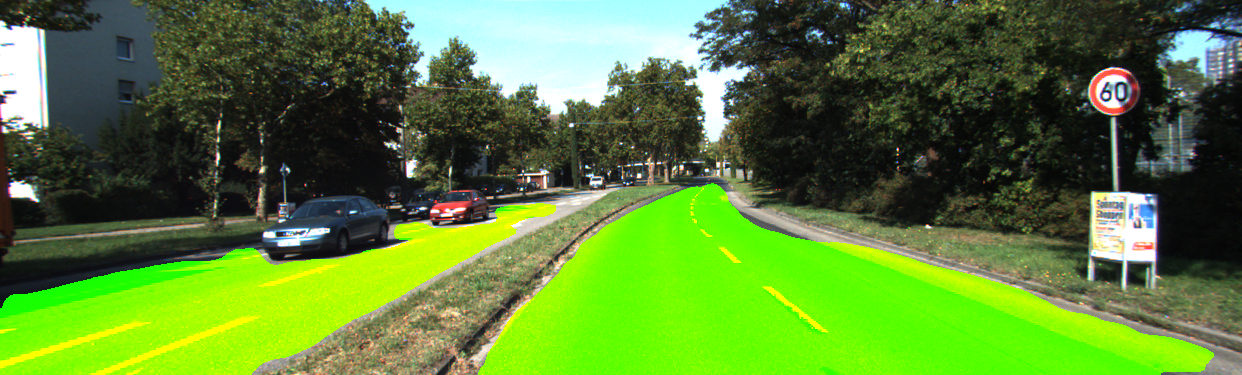

In [25]:
img_test_dir = '/content/drive/My Drive/data_kitti/testing/image_2/000012_10.png'
mask, img = test(img_test_dir, 0.80)

cv2_imshow(img)

In [0]:
img_dir_test = '/content/drive/My Drive/data_kitti/training/image_2/'
img_dir_test_label = '/content/drive/My Drive/data_kitti/labels/'

correct = 0.0
total = 0.0

for name in os.listdir(img_dir_test):
    try:
        start = time.time()  #### Measuring time (start)

        mask, masked_image = test(img_test_dir=img_dir_test+name, prob=0.85)

        time_taken = time.time() - start  #### Measuring time (diff)

        print('Time taken to execute ==>', time_taken)
        
        label = cv2.resize(cv2.imread(img_dir_test_label + name, 0), (mask.shape[1], mask.shape[0]))

        total += label.shape[0] * label.shape[1]

        for i in range(len(label)):
            for j in range(len(label[0])):
                if label[i,j] == mask[i,j]:
                    correct += 1.0
    except:
        pass

print('The test accuracy is ==> ', correct / total * 100)

Time taken to execute ==> 1.7027969360351562
Time taken to execute ==> 1.5984022617340088
Time taken to execute ==> 1.671931266784668
Time taken to execute ==> 1.6315486431121826
Time taken to execute ==> 1.6811389923095703
Time taken to execute ==> 1.6126375198364258
Time taken to execute ==> 1.6457796096801758
Time taken to execute ==> 1.6575653553009033
Time taken to execute ==> 1.6514806747436523
Time taken to execute ==> 1.6301372051239014
Time taken to execute ==> 1.6803994178771973
Time taken to execute ==> 1.6323580741882324
Time taken to execute ==> 1.6329443454742432
Time taken to execute ==> 1.6528894901275635
Time taken to execute ==> 1.6228561401367188
Time taken to execute ==> 1.6291296482086182
Time taken to execute ==> 1.630506992340088
Time taken to execute ==> 1.6767919063568115
Time taken to execute ==> 1.604722023010254
Time taken to execute ==> 1.6081831455230713
Time taken to execute ==> 1.6043007373809814
Time taken to execute ==> 1.6227443218231201
Time taken to

IsADirectoryError: ignored

In [0]:
print('The test accuracy is ==> ', correct / total * 100)

The test accuracy is ==>  95.0423889277311
